In [65]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
sns.set_palette("cubehelix", 8)#"deep")
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from problem_creator import gen_regression_symbolic, gen_classification_symbolic
from scipy.stats import weightedtau
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.evaluate import feature_importance_permutation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Utils

In [66]:
def get_y(x):
    num_features = len(x.columns)
    coeffs = [(i+1)*2 for i in range(num_features)]
    print(coeffs)
    x = x.values
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return y


### Compare Feature Importance Values under Featue Correlation

In [67]:
def train_model_compute_shap(x,y):
    model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x)
    shap_coeffs = np.absolute(shap_values).mean(axis=0)
    return shap_coeffs



def exp(degree=3, num_features=4, corr_func = lambda x: x*2, corr_f_name='f0 * 2'):
    poly = PolynomialFeatures(degree, include_bias=False, interaction_only=False)
    x = []
    data_params=[-1,1]
    data_points = 10000
    for i in range(num_features):
        x.append(np.random.uniform(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    x = pd.DataFrame(x)
    x.columns = ['f{}'.format(i) for i in range(num_features)]
    y = poly.fit_transform(x.values).sum(axis=1)
    
    shap_coeffs_before = train_model_compute_shap(x,y)
    shap_coeffs_before = shap_coeffs_before / shap_coeffs_before.sum()
    
    #add correlated feature
    x[corr_f_name] = x['f0'].apply(corr_func)
    shap_coeffs_a = train_model_compute_shap(x,y)
    shap_coeffs_a = shap_coeffs_a / shap_coeffs_a.sum()
    
    #recompute target
    y = poly.fit_transform(x.values).sum(axis=1)
    shap_coeffs_b = train_model_compute_shap(x,y)
    shap_coeffs_b = shap_coeffs_b / shap_coeffs_b.sum()
    
    return shap_coeffs_before, shap_coeffs_a, shap_coeffs_b
    
    

In [68]:
def create_result_df(degree=3, num_features=4, corr_func = lambda x: x*2, corr_f_name='f0 * 2'):
    l0 = []
    la = []
    lb = []
    for i in range(10):
        shap_coeffs_before, shap_coeffs_a, shap_coeffs_b = exp(degree, num_features, corr_func, corr_f_name)
        l0.append(shap_coeffs_before)
        la.append(shap_coeffs_a)
        lb.append(shap_coeffs_b)

    df0 = pd.DataFrame(l0)
    df0[4] = np.zeros(len(df0))
    dfa = pd.DataFrame(la)
    dfb = pd.DataFrame(lb)
    
    setup_names = ['no correlation', 'correlation A', 'correlation B']

    df_mean = pd.concat([df0.mean(0),dfa.mean(0),dfb.mean(0)],axis=1)
    df_mean.columns = setup_names
    df_mean = df_mean.T
    df_mean.columns = ['f{}'.format(i) for i in range(num_features)] + [corr_f_name]
    df_mean = df_mean.T

    df_std = pd.concat([df0.std(0),dfa.std(0),dfb.std(0)],axis=1)
    df_std.columns = setup_names
    df_std = df_std.T
    df_std.columns = ['f{}'.format(i) for i in range(num_features)] + [corr_f_name]
    df_std = df_std.T
    return df_mean, df_std

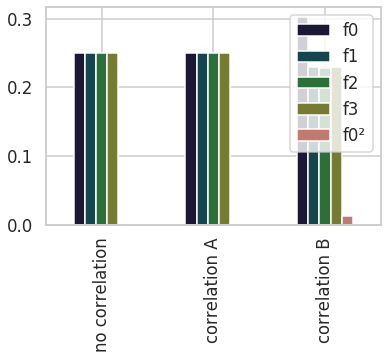

In [69]:
df_mean_nl, df_std_nl = create_result_df(corr_func = lambda x: x**2, corr_f_name='f0²')
df_mean_nl.T.plot.bar(yerr = df_std_nl)

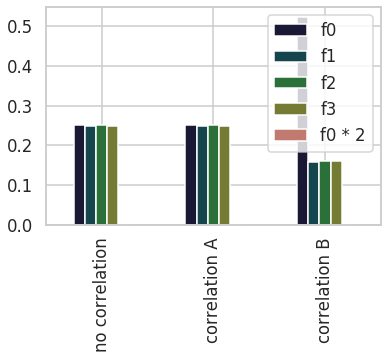

In [70]:
df_mean, df_std = create_result_df()
df_mean.T.plot.bar(yerr = df_std)

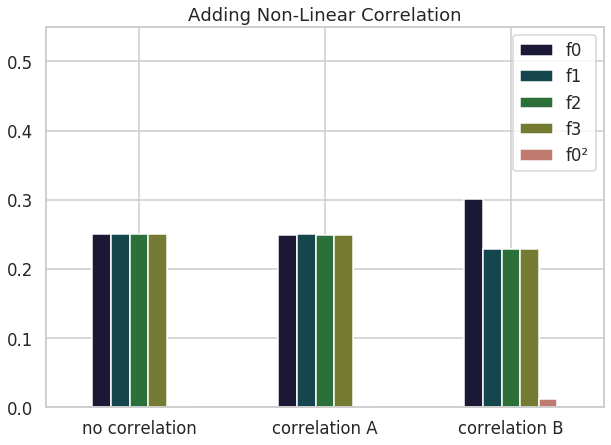

In [82]:

df_mean_nl.T.plot.bar(yerr = df_std_nl,figsize=(10,7), title = 'Adding Non-Linear Correlation')
plt.xticks(rotation=0)
plt.ylim(0,0.55)
plt.show()

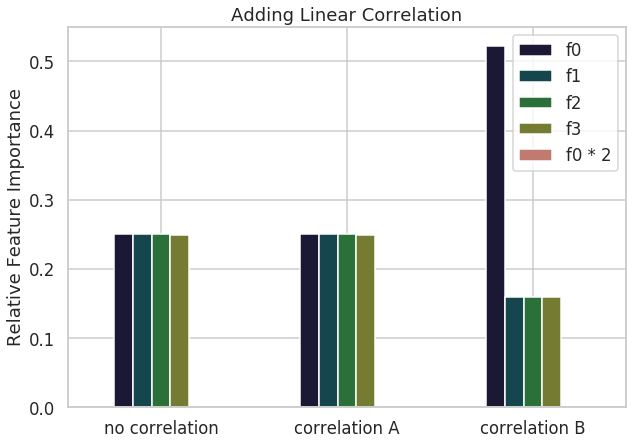

In [84]:
df_mean.T.plot.bar(yerr = df_std,figsize=(10,7), title = 'Adding Linear Correlation')
plt.xticks(rotation=0)
plt.ylim(0,0.55)
plt.ylabel('Relative Feature Importance')
plt.show()